In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 25  
plt.rcParams["xtick.labelsize"] = 20  
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'


In [28]:
# calculate bands for correlations

data = np.load('data/dsa_xi04_pTt_rs50_pn.npy', allow_pickle=True).item()

for fit in ['p', 'n']:
    for irep in range(len(data[fit])):
        data[fit][irep]['<cos(phi_Dp + phi_kp)>'] = data[fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] - data[fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
        data[fit][irep]['<cos(phi_Dp - phi_kp)>'] = data[fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] + data[fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
    
targets = ['p', 'd', 'h']
corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

for tar in targets:
    if tar == 'd':
        p,n = 1,1
        omega_d = 0.07
        Pp = 1-1.5*omega_d
        Pn = Pp

    elif tar == 'h':
        p,n = 2,1
        pS,pD,pSp = 0.9,0.1,0.02
        Pp = -(4./3.)*(pD-pSp)
        Pn = pS - (1./3.)*(pD-pSp)

    elif tar == 'p': continue

    print(tar, (Pp*p)/(p+n), (Pn*n)/(p+n))

    data[tar] = []

    for irep in range(len(data['p'])):
        tar_rep = {}
        for corr in corrs:
            p_rep = data['p'][irep][corr]
            n_rep = data['n'][irep][corr]

            # tar_rep[corr] = (p*Pp*p_rep + n*Pn*n_rep)/(p+n)
            tar_rep[corr] = p*Pp*p_rep + n*Pn*n_rep

        data[tar].append(tar_rep)
        
confid = 68

bands = {}
for tar in targets:
    bands[tar] = {}
    for obj in ['lower', 'upper', 'mean']:
        bands[tar][obj] = {}

    for corr in corrs:
        corr_reps = [rep[corr] for rep in data[tar]]
        bands[tar]['mean'][corr] = np.mean(corr_reps, axis=0)
        bands[tar]['lower'][corr] = np.mean(corr_reps, axis=0) - np.std(corr_reps, axis=0)
        bands[tar]['upper'][corr] = np.mean(corr_reps, axis=0) + np.std(corr_reps, axis=0)
        # bands[tar]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0)
        # bands[tar]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0)


lumi = 100
errors = {}
errors['all'] = np.sqrt(1/(2*lumi*np.array(data['p'][0]['denom'])))
errors['corr'] = np.sqrt(2/(2*lumi*np.array(data['p'][0]['denom'])))

pT_values = data['pT values']
roots = data['roots']
space = data['space']
r0 = data['r0']

space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])

info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'

for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            info_text += fr'$\overline{{Q}}_0 \, = \,{r0}\, \mathrm{{GeV}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


d 0.4475 0.4475
h -0.07111111111111111 0.29111111111111115


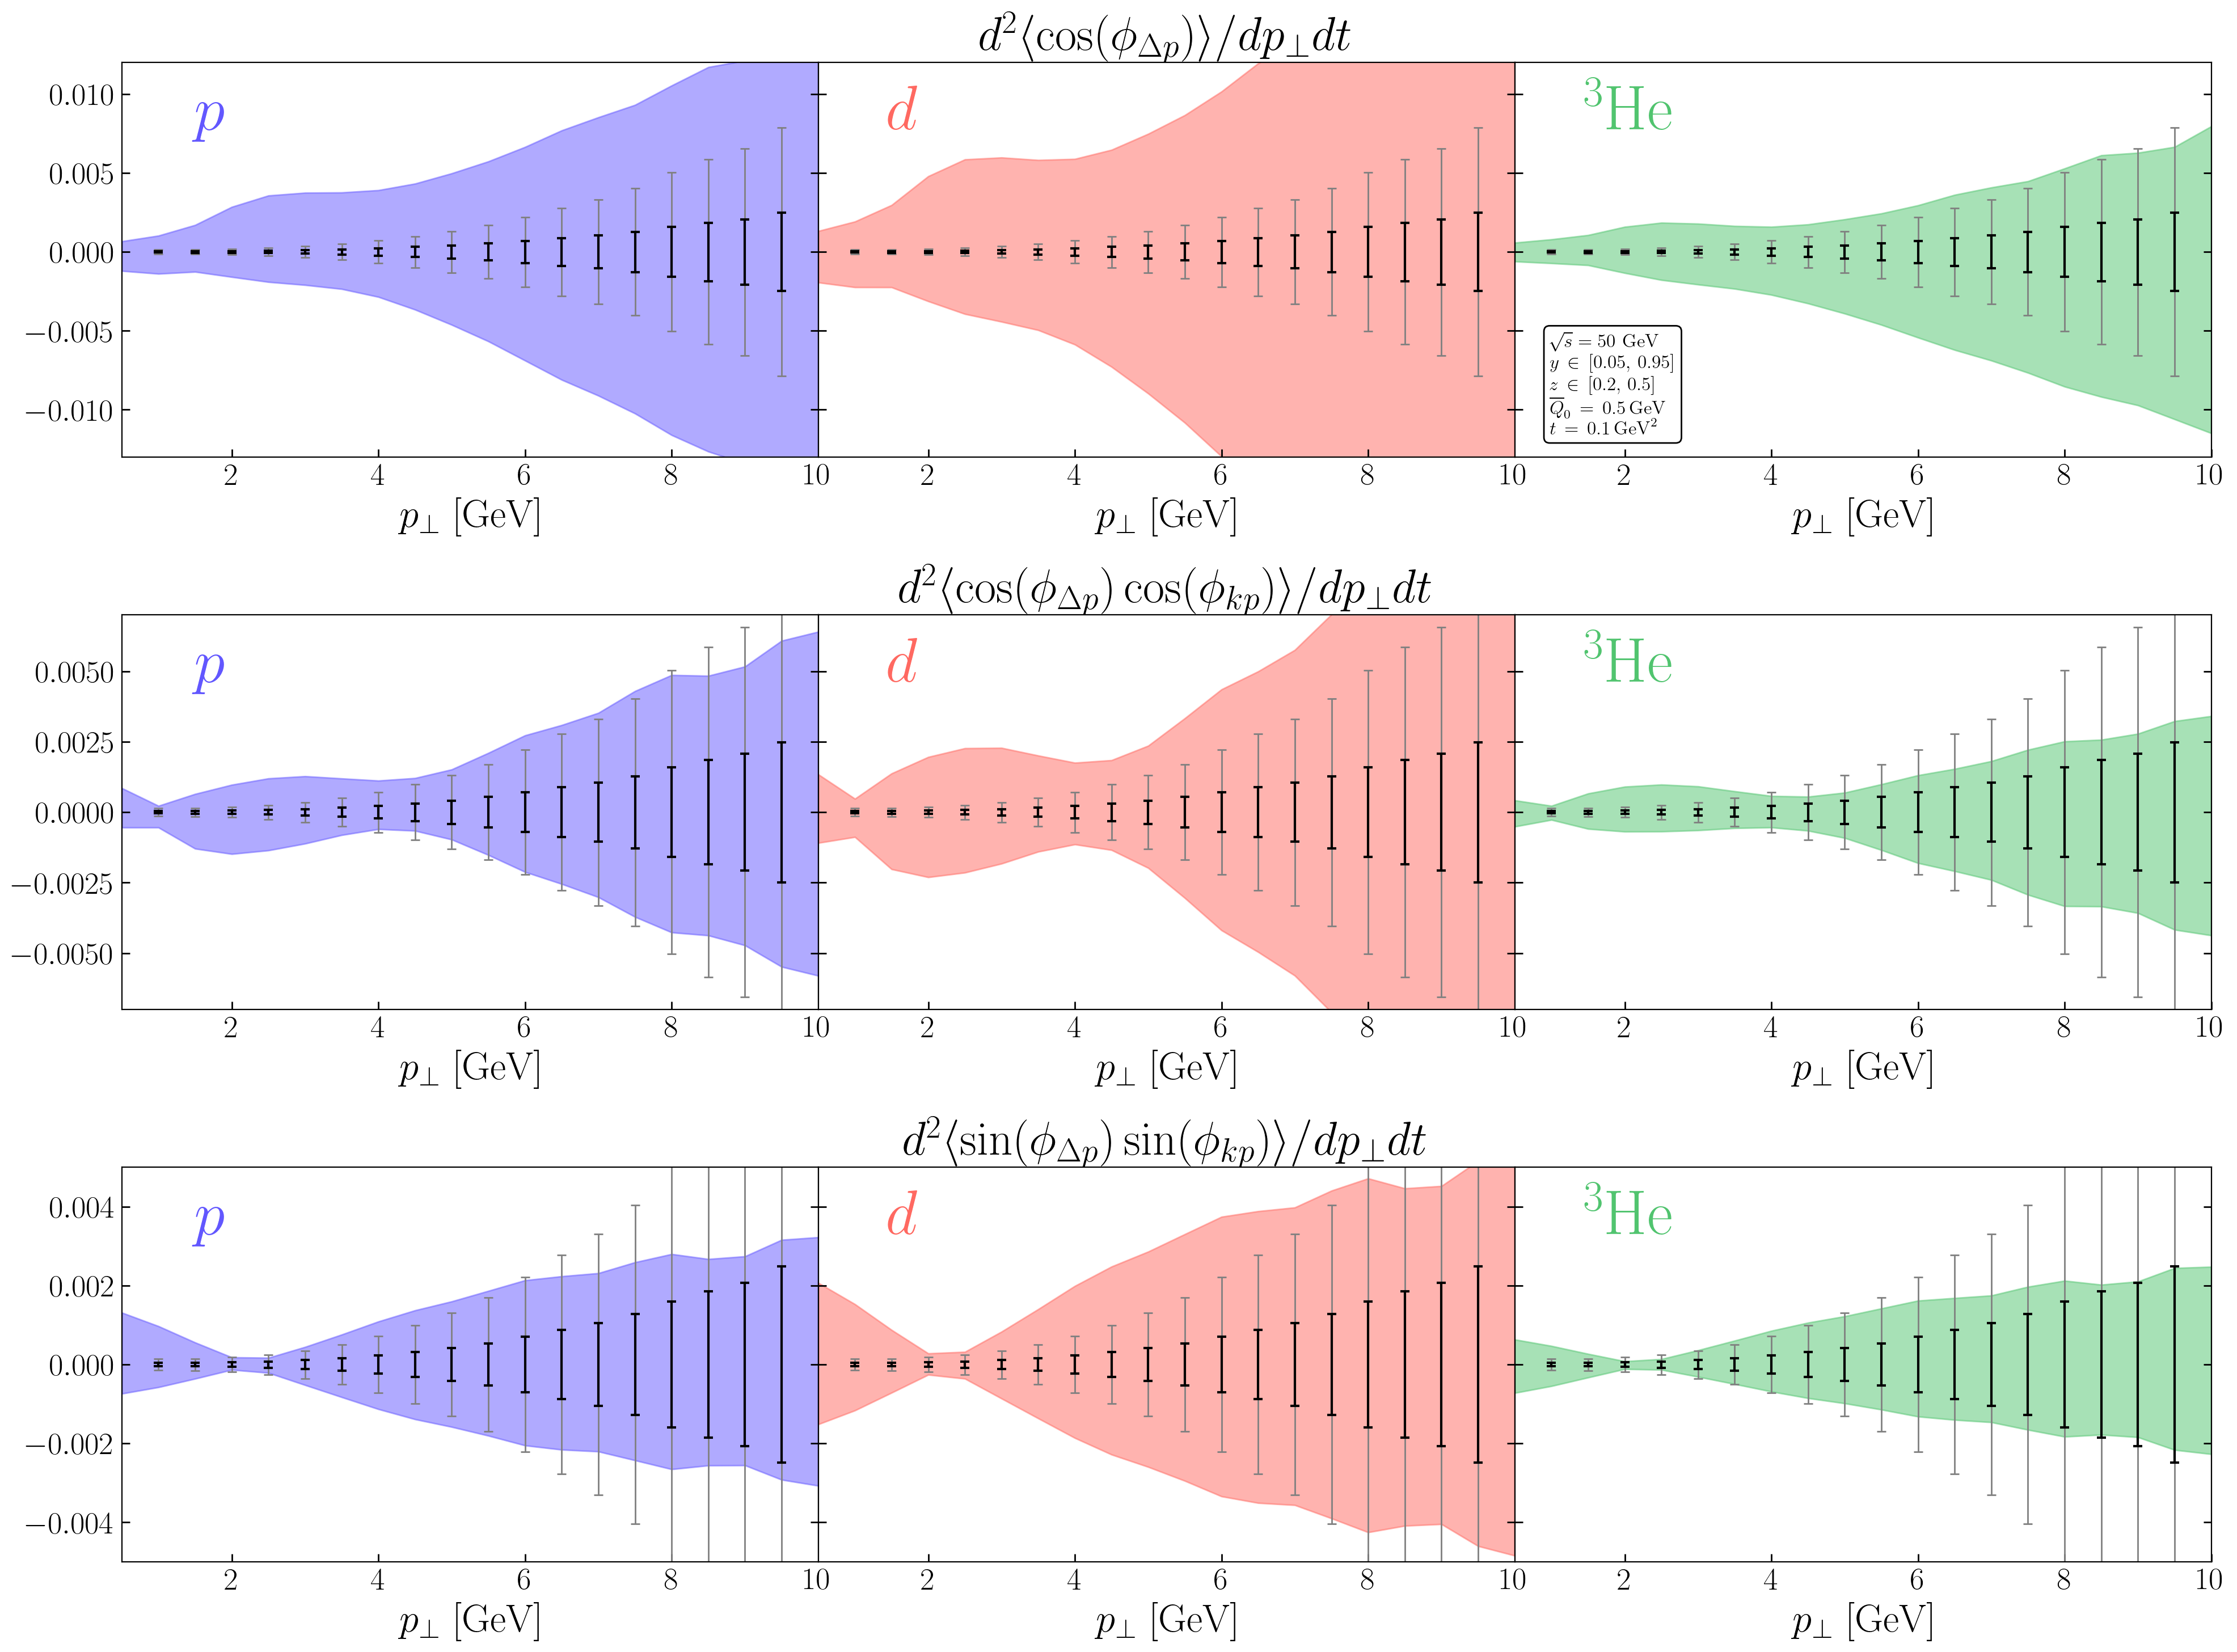

In [29]:
# plot azimuthal correlations
asp_ratio = 4/3
psize = 5

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows), sharey='row')

plot_bands = True
alt_defs = False
plot_stat_errors = True

# colors = ['red', 'blue', 'green']
# colors = ['#FF6961', '#6257ff', '#51c46f']
colors = ['#6257ff', '#FF6961', '#51c46f']
# labels = ['DIS+SIDIS', '+pp', '+pp (constrained moments)']

# colors = ['#51c46f', '#6257ff']
# labels = ['+pp', '+pp (constrained moments)']

# corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
corrs = ['<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
if alt_defs: corrs = ['<cos(phi_Dp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

for itar, tar in enumerate(targets):
    for icorr, corr in enumerate(corrs):

        if plot_bands:
            # axs[icorr].plot(pT_values, bands[fit]['mean'][corr], color=colors[ifit])
            ax[icorr,itar].fill_between(pT_values, bands[tar]['lower'][corr], bands[tar]['upper'][corr], color=colors[itar], alpha=0.5)
        
        else:
            for irep, rep in enumerate(data[tar]):
                ax[icorr, itar].plot(pT_values, np.array(rep[corr]), alpha=0.3, color=colors[itar])

        if plot_stat_errors:
            ax[icorr, itar].errorbar(
                    pT_values[1:-1], np.zeros(errors['corr'][1:-1].shape), yerr=np.sqrt(10)*errors['corr'][1:-1], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='gray', markersize=0, 
                    label=rf'Absolute error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
            )
            ax[icorr,itar].errorbar(
                    pT_values[1:-1], np.zeros(errors['corr'][1:-1].shape), yerr=errors['corr'][1:-1], fmt='o',
                    capsize=3, elinewidth=1.5, capthick=1.5, color='black', markersize=0, 
                    label=rf'Absolute error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
            )


tar_labels = [r'$p$', r'$d$', r'$^3\mathrm{He}$']
for itar, tar in enumerate(targets):    
    # ax[itar, 0].axhline(y=0, color='lightgray', linestyle='--')
    ax[0, itar].set_xlabel(r'$p_\perp$ [GeV]')
    if itar == 1: ax[0,itar].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}}) \rangle / {den_label} $', size=30)
    ax[itar, 0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
    # ax[itar, 0].legend(frameon=False)
    ax[0, itar].set_ylim([-0.013, 0.012])
    # ax[itar, 0].semilogy()
    
    
    # ax[itar, 1].axhline(y=0, color='lightgray', linestyle='--')
    ax[1,itar].set_xlabel(r'$p_{\perp}$ [GeV]')
    if alt_defs:
        if itar == 1: ax[1,itar].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}} + \phi_{{k p}}) \rangle / {den_label} $', size=30)
    else: 
        if itar == 1: ax[1,itar].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / {den_label} $', size=30)
    ax[itar, 1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
    # ax[itar, 1].legend(frameon=False)
    ax[1,itar].set_ylim([-0.007, 0.007])
    # ax[itar, 1].semilogy()

    # ax[itar, 2].axhline(y=0, color='lightgray', linestyle='--')
    ax[2,itar].set_xlabel(r'$p_{\perp}$ [GeV]')
    if alt_defs:
        if itar == 1: ax[2, itar].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}} - \phi_{{k p}})  \rangle / {den_label} $', size=30)
    else:
        if itar == 1: ax[2, itar].set_title(fr'$ d^{num_label} \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle / {den_label} $', size=30)
    ax[itar, 2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
    # ax[itar, 2].legend(frameon=False)
    ax[2,itar].set_ylim([-0.005, 0.005])
    # ax[itar, 2].semilogy()
    # axs[1].legend()


    for i in range(3):
        ax[i,itar].text(
            0.1, 0.8, tar_labels[itar], 
            transform=ax[i,itar].transAxes,
            ha='left', va='bottom', 
            fontsize=40, wrap=True, 
            color=colors[itar],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
            
        )
ax[0, 2].text(
    0.05, 0.05, info_text, 
    transform=ax[0, 2].transAxes,
    ha='left', va='bottom', 
    fontsize=12, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.subplots_adjust(wspace=0)
plt.show()

# if plot_bands:
#     fig.savefig('plots/dsa_band_targets.pdf', dpi=400, bbox_inches="tight")
# else:
#     fig.savefig('plots/dsa_lines_targets.pdf', dpi=400, bbox_inches="tight")
